# Climate Analysis and Exploration

### Import useful modules

In [18]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from scipy import stats
import sqlalchemy as sa
from sqlalchemy import create_engine, func, inspect, or_
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy.sql import label

### For the plots, emulate the style of the ABS News site [FiveThirtyEight](fivethirtyeight.com)

In [19]:
plt.style.use('fivethirtyeight')

### Reflect Tables into SQLAlchemy ORM

In [20]:
# Create an engine to connect to the climate database for Hawaii
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Create a session for ORM queries
session = Session(engine)

# Use the base for reflection an existing database
Base = automap_base()

# Reflect the database content
Base.prepare(engine, reflect=True)

# list the tables
Base.classes.keys()

['measurement', 'station']

In [21]:
# Explore the columns of the tables
def describe_table(table_name, engine):
    print(f'\nTable:  {table_name}')
    insp = inspect(engine)
    [print(c['name'], c['type']) for c in insp.get_columns(table_name)]
    
describe_table('measurement', engine)
describe_table('station', engine)


Table:  measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Table:  station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [22]:
# Create local aliases to the tables
Measurement = Base.classes['measurement']
Station = Base.classes['station']

## Precipitation Analysis

### Retrieve the last 12 months of precipitation data.

In [23]:
# The vacation location and dates both depend on the available stations, and the quality of their weather data.
q = session.query(Station.name,
                  Station.station,
                  label('min_date', func.min(Measurement.date)),
                  label('max_date', func.max(Measurement.date)),
                  label('measurement_count', func.count(Measurement.date)))\
.group_by(Station.name)\
.filter(Station.station == Measurement.station)

# Determine the actual days (inclusive) between min_date and max_date, to check the density of measurements
df_station = pd.DataFrame(q)
df_station['actual_days']=((pd.to_datetime(df_station.max_date, format="%Y-%m-%d") 
                    - pd.to_datetime(df_station.min_date, format="%Y-%m-%d"))/np.timedelta64(1, 'D')).astype(int)
df_station['measurement_density'] = df_station.measurement_count/df_station.actual_days
df_station.sort_values('measurement_density', ascending=False, inplace=True, ignore_index=True)
df_station

,name,station,min_date,max_date,measurement_count,actual_days,measurement_density
0,"WAIHEE 837.5, HI US",USC00519281,2010-01-01,2017-08-18,2772,2786,0.994975
1,"KANEOHE 838.1, HI US",USC00513117,2010-01-01,2017-07-31,2709,2768,0.978685
2,"WAIKIKI 717.2, HI US",USC00519397,2010-01-01,2017-08-23,2724,2791,0.975994
3,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,2010-01-01,2017-08-23,2669,2791,0.956288
4,"MANOA LYON ARBO 785.2, HI US",USC00516128,2010-01-01,2017-08-23,2612,2791,0.935865
5,"HONOLULU OBSERVATORY 702.2, HI US",USC00511918,2010-01-01,2015-10-30,1979,2128,0.929981
6,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,2010-03-01,2017-08-23,2202,2732,0.806003
7,"PEARL CITY, HI US",USC00517948,2010-05-03,2017-07-31,1372,2646,0.518519
8,"UPPER WAHIAWA 874.3, HI US",USC00518838,2010-01-01,2015-11-20,511,2149,0.237785


In [24]:
# This function is very narrow, but quick and accurate, and does not require the DateTime module
#    It handles only string input, in the form "YYYY-MM-DD"
#    It handles leap years with functionality equivalent to SQL Server's dateadd(yy, ...) implementation
# I could use Python's datetime module and subtract a Timedelta of 365 days,
# but that would be more computationally expensive, and still not handle leap years.
def YearBefore(YYYY_MM_DD):
    _MM_DD = YYYY_MM_DD[4:10]
    if _MM_DD == "_02_29":
        _MM_DD = "_02_28"
    return str(int(YYYY_MM_DD[0:4])-1) + _MM_DD

# The Waihee station has the highest "measurement density".  I will vacation there.
# I will enjoy Waihee from 2018-03-10 to 2018-03-18,
# to take my wife for her Spring Break and my birthday,
# and to get there before COVID-19.
vacation_location = df_station.name[0]
vacation_station = df_station.station[0]
trip_start = '2018-03-10'
trip_end = '2018-03-18'
study_end_date = df_station.max_date[0]

In [25]:
# Query the last twelve months of precipitation data for my vacation location to a Pandas DataFrame
df_prcp = pd.DataFrame(
    session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.station == vacation_station,Measurement.date > YearBefore(study_end_date))\
    .order_by(Measurement.date))
df_prcp.date = pd.to_datetime(df_prcp.date, format="%Y-%m-%d")
df_prcp.set_index('date', inplace=True)

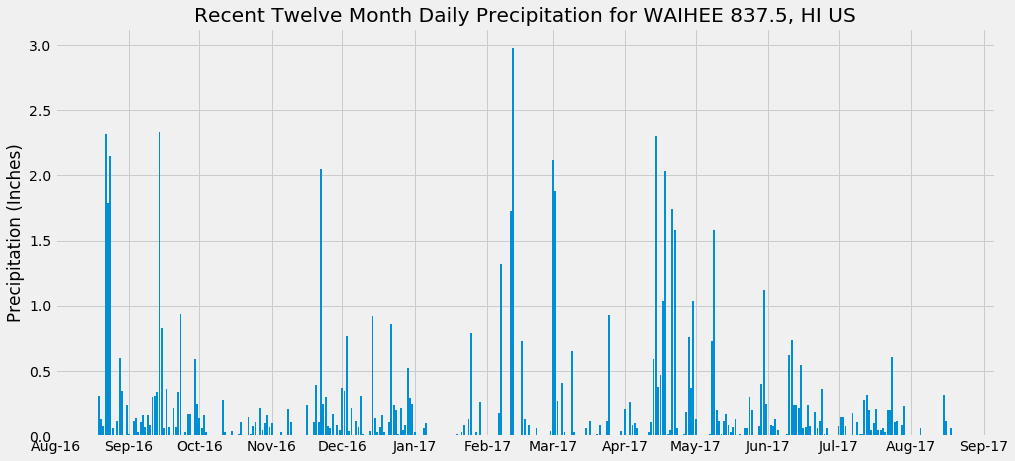

In [26]:
# Plot the precipitation data
fig1, ax = plt.subplots(figsize=(15,7))
ax.bar(df_prcp.index, df_prcp.prcp)
# Set ticks every Month, with a Mmm-yy date format
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

ax.set_title(f"Recent Twelve Month Daily Precipitation for {vacation_location}")
_ = ax.set_ylabel("Precipitation (Inches)")

In [27]:
plt.close(fig1)
# Use Pandas to calculate the summary statistics for the precipitation data
df_prcp.describe()

,prcp
count,356.000000
mean,0.204691
std,0.431811
min,0.000000
25%,0.000000
50%,0.060000
75%,0.192500
max,2.980000


## Station Analysis

### Station Count and Activity

In [28]:
print(f"""The station analysis was performed above, to select a vacation spot.
Of the {df_station.shape[0]} stations, {df_station.name[0]} was the most active, 
with {df_station.measurement_count[0]} measurements.""")

The station analysis was performed above, to select a vacation spot.
Of the 9 stations, WAIHEE 837.5, HI US was the most active, 
with 2772 measurements.


### Analyze the last twelve months of observed temperatures.

In [29]:
# Query the last twelve months of temperature data for my vacation location to a Pandas DataFrame
df_tobs = pd.DataFrame(
    session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.station == vacation_station,Measurement.date > YearBefore(study_end_date))\
    .order_by(Measurement.date))
df_tobs.date = pd.to_datetime(df_tobs.date, format="%Y-%m-%d")
df_tobs.set_index('date', inplace=True)

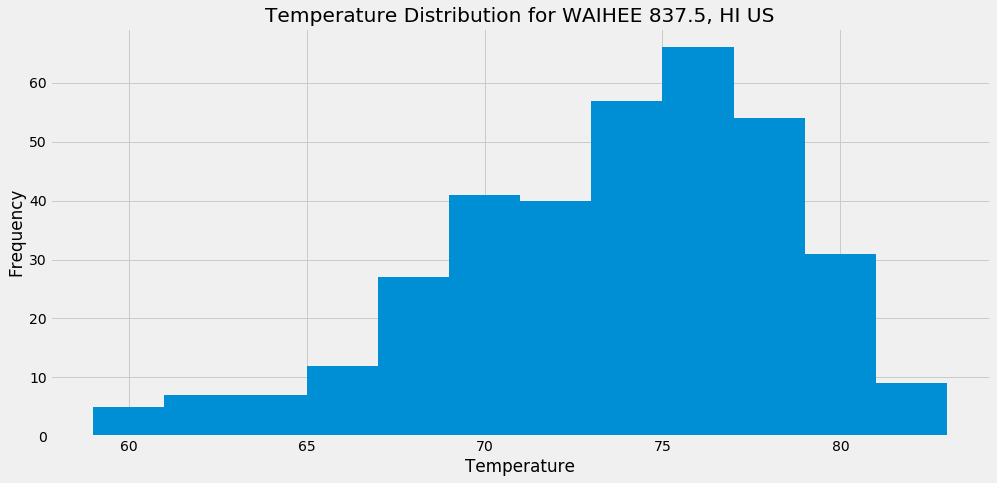

In [30]:
# Plot a histogram of the temperature data
fig2, ax = plt.subplots(figsize=(15,7))
ax.hist(df_tobs.tobs,bins=12)

ax.set_title(f"Temperature Distribution for {vacation_location}")
ax.set_xlabel("Temperature")
_ = ax.set_ylabel("Frequency")

In [31]:
plt.close(fig2)

## Temperature Analysis I

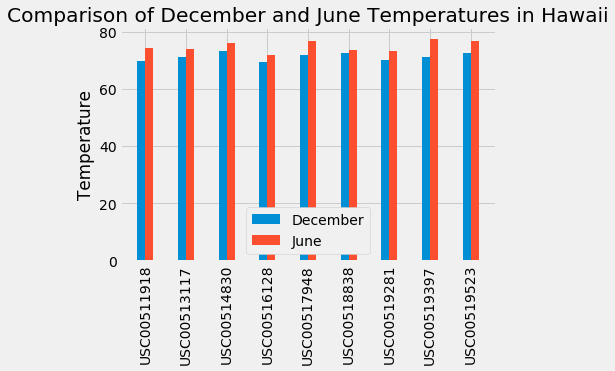

In [49]:
# Select average June temperatures, by station.
jun_avg = pd.DataFrame(session.query(Measurement.station,
                                     label('avg_tobs', func.avg(Measurement.tobs)),
                                     label('count_tobs', func.count(Measurement.tobs))
                                     ).filter(Measurement.date.like('%-06-%')).group_by(Measurement.station))
# Select average December temperatures, by station.
dec_avg = pd.DataFrame(session.query(Measurement.station,
                                     label('avg_tobs', func.avg(Measurement.tobs)),
                                     label('count_tobs', func.count(Measurement.tobs))
                                     ).filter(Measurement.date.like('%-12-%')).group_by(Measurement.station))
# Merge the Data Frames
jun_dec = jun_avg.merge(dec_avg, on='station', suffixes=['_jun','_dec'])

# Plot the temperaures
fig3 = plt.figure(3)
plt.bar(x=jun_dec.station, height=jun_dec.avg_tobs_dec, width=-0.2, align='edge', label="December")
plt.bar(x=jun_dec.station, height=jun_dec.avg_tobs_jun, width=0.2, align='edge', label="June")
plt.xticks(rotation=90)
plt.legend(loc='lower center',framealpha=1)
plt.ylabel('Temperature')
_ = plt.title('Comparison of December and June Temperatures in Hawaii')

## Is the difference significant?
* Test the suitability of the data for a t-test
* Perform the t-test

### Check for outliers

<Figure size 432x288 with 0 Axes>

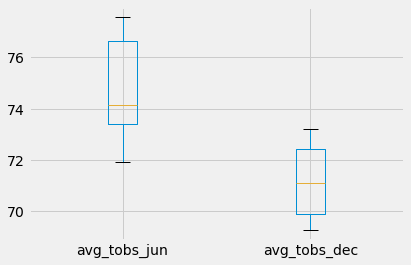

In [53]:
plt.close(fig3)
fig4 = plt.figure(4)
_ = jun_dec[['avg_tobs_jun', 'avg_tobs_dec']].plot(kind='box')

### Check for a normal distribution

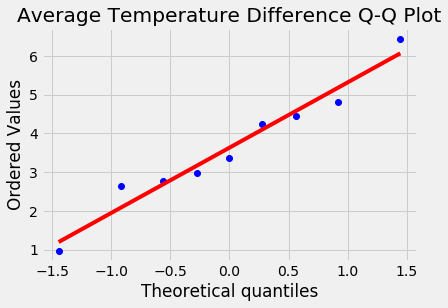

In [34]:
plt.close(fig4)
### Check for a normal distribution of Jun - Dec temperature differences
jun_dec['avg_tobs_diff'] = jun_dec.avg_tobs_jun - jun_dec.avg_tobs_dec
fig5 = plt.figure(5)
stats.probplot(jun_dec.avg_tobs_diff, plot= plt)
_ = plt.title('Average Temperature Difference Q-Q Plot')

### Perform the t-test between the June and December average temperatures

In [35]:
plt.close(fig5)
# Perform a paired t-test, because the temperatures are measured on the same stations in June and December
t, p = stats.ttest_rel(jun_dec.avg_tobs_jun, jun_dec.avg_tobs_dec)
print(f'The computed t-value, {t:.2f}, shows low probability, {p:.4%}, that the temperature difference is insignificant.')

The computed t-value, 6.96, shows low probability, 0.0118%, that the temperature difference is insignificant.


## Temperature Analysis II
* Compute the min, avg, and max temperatures for the previous year during my vacation dates
* Plot those expected temperatures

### Compute the min, avg, and max temperures

In [36]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date,Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [37]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
[min_temp, avg_temp, max_temp] = calc_temps(YearBefore(trip_start),YearBefore(trip_end))[0]

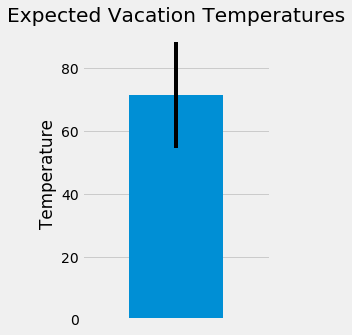

In [38]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig6 = plt.figure(6,figsize=(3,5))
plt.bar(x=0,height=avg_temp,width=0.2,yerr=max_temp - min_temp)
plt.xlim(-0.2,0.2)
plt.xticks([])
plt.ylabel('Temperature')
_ = plt.title('Expected Vacation Temperatures')

## Daily Expected Rainfall and Temperatures

### Typical rainfall by station, based on the previous year, for my vacation period

In [39]:
plt.close(fig6)

# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
pd.DataFrame(
    session.query(Station.station,
                  Station.name,
                  Station.latitude,
                  Station.longitude,
                  Station.elevation,
                  label('total_rainfall', func.sum(Measurement.prcp)))\
    .group_by(Station.name)\
    .filter(Station.station == Measurement.station,
            Measurement.date >= YearBefore(trip_start),
           Measurement.date <= YearBefore(trip_end))\
).sort_values('total_rainfall', ascending=False)

,station,name,latitude,longitude,elevation,total_rainfall
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.35
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.35
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.22
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.19
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.06
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.00
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00


### Daily temperature range, based on the previous year, for my vacation period

In [40]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [41]:
# Set the start and end date of the trip
dt_start = dt.datetime.strptime(trip_start,'%Y-%m-%d')
dt_end = dt.datetime.strptime(trip_end,'%Y-%m-%d')

# Use the start and end date to create a range of dates
date_range = [dt_start + dt.timedelta(days=x) for x in range(0, (dt_end-dt_start).days+1)]

# Strip off the year and save a list of %m-%d strings
# Calculate the normals for each date
lt = [daily_normals(x.strftime('%m-%d'))[0] for x in date_range]

In [42]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_temps = pd.DataFrame.from_records(lt, index=date_range, columns=['tmin','tavg','tmax'])

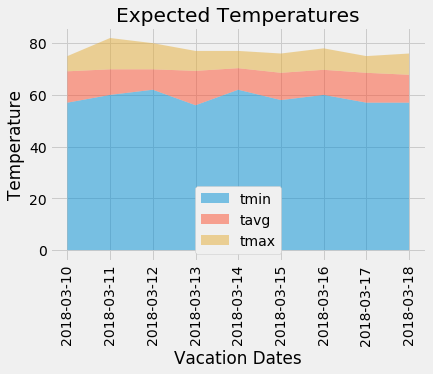

In [50]:
# Plot the daily normals as an area plot with `stacked=False`
fig7 = plt.figure(7)
#expected_temps.plot()

plt.fill_between(x=daily_temps.index, y1=daily_temps.tmin, label='tmin', alpha=0.5)
plt.fill_between(x=daily_temps.index, y1=daily_temps.tavg, y2 = daily_temps.tmin, label='tavg', alpha=0.5)
plt.fill_between(x=daily_temps.index, y1=daily_temps.tmax, y2 = daily_temps.tavg, label='tmax', alpha=0.5)
plt.legend(loc='lower center',framealpha=1)
plt.xticks(rotation=90)
plt.title('Expected Temperatures')
plt.xlabel('Vacation Dates')
_ = plt.ylabel('Temperature')

In [44]:
plt.close(fig7)
session.close()
engine.dispose()